# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.model import get_model_simple, get_model_bhm, get_model_bhm_nc, get_model_logres, get_model_logres_nc

## 1. Generate some data

In [5]:
np.random.seed(42)

In [6]:
# set the number of baskets and clusters
n_baskets = 10
n_clusters = 5

# generate some synthetic basket and cluster probabilities
true_basket_p = np.random.beta(2, 5, size=n_baskets)
true_cluster_p = np.random.beta(5, 2, size=n_clusters)
true_mat = np.outer(true_basket_p, true_cluster_p)
true_basket_p, true_cluster_p, true_mat

(array([0.35367666, 0.24855807, 0.41595909, 0.15996758, 0.55028308,
        0.11094529, 0.50989664, 0.17727038, 0.19829047, 0.37623679]),
 array([0.92581161, 0.54806457, 0.77267222, 0.77178197, 0.52109289]),
 array([[0.32743795, 0.19383764, 0.27327613, 0.27296127, 0.18429839],
        [0.23011794, 0.13622587, 0.19205391, 0.19183263, 0.12952184],
        [0.38509975, 0.22797244, 0.32140003, 0.32102972, 0.21675332],
        [0.14809984, 0.08767256, 0.1236025 , 0.12346009, 0.08335797],
        [0.50945846, 0.30159066, 0.42518845, 0.42469856, 0.2867486 ],
        [0.10271443, 0.06080518, 0.08572434, 0.08562557, 0.0578128 ],
        [0.47206823, 0.27945628, 0.39398297, 0.39352903, 0.26570351],
        [0.16411897, 0.09715561, 0.1369719 , 0.13681408, 0.09237433],
        [0.18357962, 0.10867598, 0.15321354, 0.15303701, 0.10332775],
        [0.34832439, 0.20620205, 0.29070772, 0.29037277, 0.19605431]]))

In [7]:
# generate some synthetic data
data = []
for i in range(n_baskets):
    for j in range(n_clusters):
        
        # probability of a patient being responsive in this basket and cluster combination
        p = true_basket_p[i] * true_cluster_p[j]
        
        # number of patients in this basket and cluster
        n = np.random.randint(1, 30)
        
        # generate the data
        responsive = np.random.binomial(1, p, size=n)
        data += [(i, j, r) for r in responsive]

# convert the data to a pandas dataframe
data = pd.DataFrame(data, columns=['basket_number', 'cluster_number', 'responsive'])
data

,basket_number,cluster_number,responsive
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
695,9,4,0
696,9,4,0
697,9,4,0
698,9,4,1


## 2. Define models

No. of samples to collect before and after burn-in during MCMC.

In [8]:
n_burn_in = int(1E3)
n_sample = int(1E3)
target_accept = 0.99

In [9]:
n_baskets = len(data['basket_number'].unique())
n_clusters = len(data['cluster_number'].unique())
n_baskets, n_clusters

(10, 5)

Simple model

In [10]:
with pm.Model() as model:
    
    # prior probability of each basket being responsive
    basket_p = pm.Beta('basket_p', alpha=2, beta=5, shape=n_baskets)
    
    # prior probability of each cluster being responsive
    cluster_p = pm.Beta('cluster_p', alpha=5, beta=2, shape=n_clusters)
    
    # responsive is a product of each combination of basket and cluster probabilities
    basket_idx = data['basket_number'].values
    cluster_idx = data['cluster_number'].values
    is_responsive = data['responsive'].values
    y = pm.Bernoulli('y', p=basket_p[basket_idx] * cluster_p[cluster_idx], observed=is_responsive)

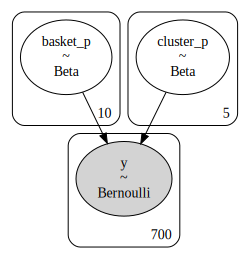

In [11]:
pm.model_to_graphviz(model)

The hierarchical model suffers from a lot of divergences. See https://discourse.pymc.io/t/non-centered-parameterization-of-a-beta-distribution/6872/7

In [12]:
with pm.Model() as model:
    
    # hyperpriors for basket_p and cluster_p
    alpha_b = pm.Beta('alpha_b', alpha=2, beta=2)
    beta_b = pm.Beta('beta_b', alpha=2, beta=2)
    alpha_c = pm.Beta('alpha_c', alpha=2, beta=2)
    beta_c = pm.Beta('beta_c', alpha=2, beta=2)    
    
    # prior probability of each basket being responsive
    basket_p = pm.Beta('basket_p', alpha=alpha_b, beta=beta_b, shape=n_baskets)
    
    # prior probability of each cluster being responsive
    cluster_p = pm.Beta('cluster_p', alpha=alpha_c, beta=beta_c, shape=n_clusters)
    
    # responsive is a product of each combination of basket and cluster probabilities
    basket_idx = data['basket_number'].values
    cluster_idx = data['cluster_number'].values
    is_responsive = data['responsive'].values
    y = pm.Bernoulli('y', p=basket_p[basket_idx] * cluster_p[cluster_idx], observed=is_responsive)

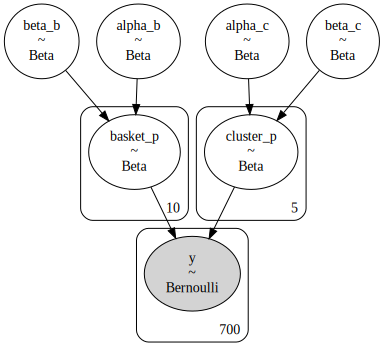

In [13]:
pm.model_to_graphviz(model)

In [14]:
with model:
    trace = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_b, beta_b, alpha_c, beta_c, basket_p, cluster_p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6373, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


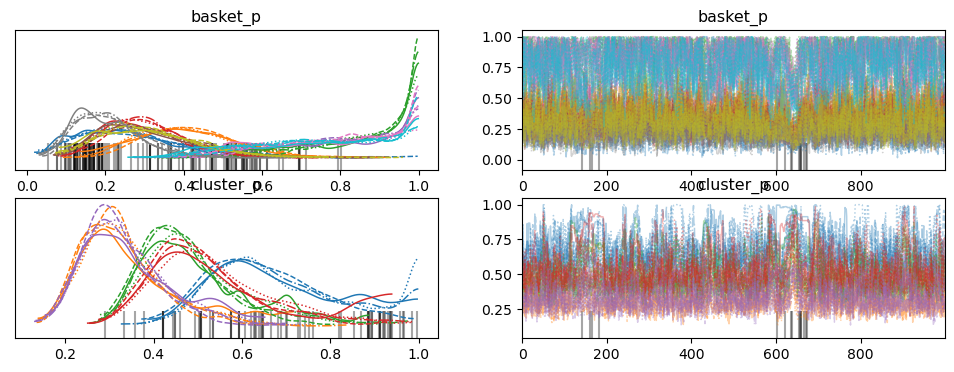

In [15]:
az.plot_trace(trace, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

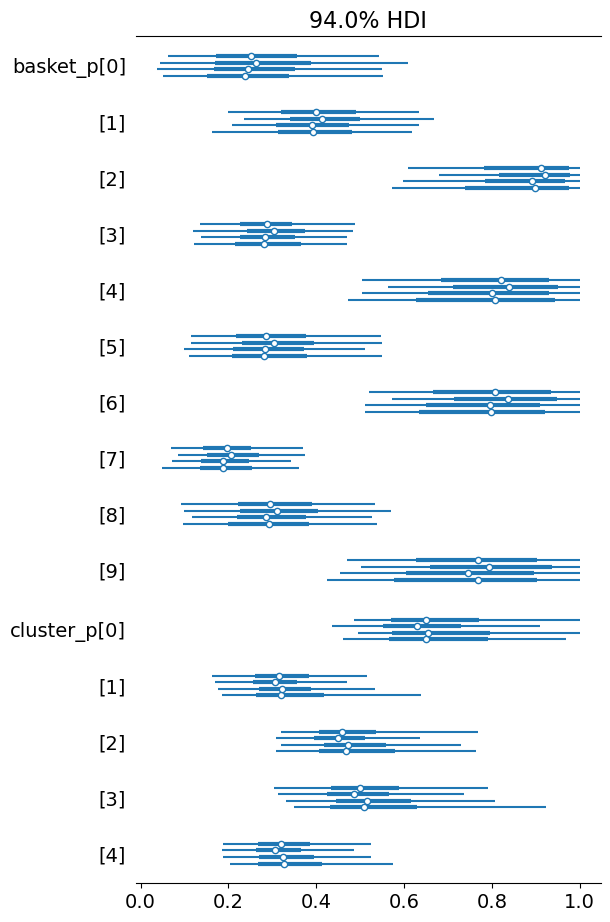

In [16]:
az.plot_forest(trace, var_names=['basket_p', 'cluster_p'])

In [17]:
stacked = az.extract(trace)

In [18]:
inferred_basket_p = stacked.basket_p.values[:, 0]
true_basket_p, inferred_basket_p, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

(array([0.35367666, 0.24855807, 0.41595909, 0.15996758, 0.55028308,
        0.11094529, 0.50989664, 0.17727038, 0.19829047, 0.37623679]),
 array([0.23686193, 0.56237834, 0.98485822, 0.39507863, 0.99991923,
        0.47871646, 0.98249976, 0.37476453, 0.51946778, 0.99929351]),
 0.39776786665146235)

In [19]:
inferred_cluster_p = stacked.cluster_p.values[:, 0]
true_cluster_p, inferred_cluster_p, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

(array([0.92581161, 0.54806457, 0.77267222, 0.77178197, 0.52109289]),
 array([0.5023495 , 0.24326051, 0.43012575, 0.3813853 , 0.21599991]),
 0.35638603656660506)

In [20]:
inferred_mat = np.outer(inferred_basket_p, inferred_cluster_p)
true_mat, inferred_mat

(array([[0.32743795, 0.19383764, 0.27327613, 0.27296127, 0.18429839],
        [0.23011794, 0.13622587, 0.19205391, 0.19183263, 0.12952184],
        [0.38509975, 0.22797244, 0.32140003, 0.32102972, 0.21675332],
        [0.14809984, 0.08767256, 0.1236025 , 0.12346009, 0.08335797],
        [0.50945846, 0.30159066, 0.42518845, 0.42469856, 0.2867486 ],
        [0.10271443, 0.06080518, 0.08572434, 0.08562557, 0.0578128 ],
        [0.47206823, 0.27945628, 0.39398297, 0.39352903, 0.26570351],
        [0.16411897, 0.09715561, 0.1369719 , 0.13681408, 0.09237433],
        [0.18357962, 0.10867598, 0.15321354, 0.15303701, 0.10332775],
        [0.34832439, 0.20620205, 0.29070772, 0.29037277, 0.19605431]]),
 array([[0.11898747, 0.05761915, 0.10188042, 0.09033566, 0.05116216],
        [0.28251048, 0.13680444, 0.24189341, 0.21448283, 0.12147367],
        [0.49474303, 0.23957711, 0.42361288, 0.37561045, 0.21272929],
        [0.19846755, 0.09610703, 0.16993349, 0.15067718, 0.08533695],
        [0.5023089

Text(537.310606060606, 0.5, 'Baskets')

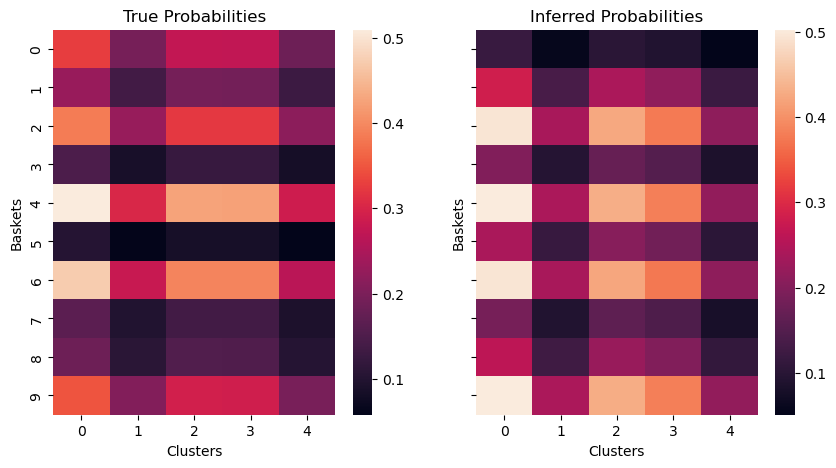

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

sns.heatmap(true_mat, ax=ax[0])
ax[0].set_title('True Probabilities')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat, ax=ax[1])
ax[1].set_title('Inferred Probabilities')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')